# TouchTerrain standalone in a jupyter notebook
Chris Harding, Dec. 24, 2022 (<charding@iastate.edu>)

- This jupyter notebook runs a standalone version of TouchTerrain, similar to `TouchTerrain_standalone.py`
- This notebook needs to be run in Python __3.x__  
- If you're using this via the touchterrain_jupyter docker container, ignore all the install stuff that follows. The image will already contain nearly all packages, except for the touchterrain module itself, which you should already have installed via the install_touchterrain.sh shell script. You might want to rename/save this notebook into something other than TouchTerrain_standalone_jupyter_notebook.ipnb b/c if you ever update the touchterrain module from github (update_touchterrain.sh) it will overwrite it!


- Use pip to build and install a package called touchterrain (all lowercase!), which contains all functions needed to run in standalone and in server mode. This will also install all dependencies needed(!)
- you can run pip either in a terminal or inside a jupyter cell (see cell below)
- to run it in a separate terminal, `cd` to the folder that contains the `setup.py` file (which will contain a folder called touchterrain)
    - enter:  `pip install .` 
    - note the . at the end, which will make pip run the script in setup.py
    - this will install all dependencies (including earthengine-api) 
- You will also need to install __gdal__ which can be tricky when using pip as it requires a C++ compiler. Because of many Windows users not wanting to go that route, it's commented out in setup.py, but if you do have a working compiler you can uncomment it and see if it works with pip.
- On Windows you could get the whl file for your version of Python from [here](https://www.lfd.uci.edu/~gohlke/pythonlibs/) and install it separately with `pip install <whl file>` (Note that this is sadly no longer being updated!)
- gdal is also available via [conda-forge](https://anaconda.org/conda-forge/gdal) and if you have conda installed you could try: `conda install -c conda-forge gdal` 
- Finally. there are two optional modules which you may want to install via pip as well:
    - `pip install geemap`  will allow you to use an interactive in-cell map to digitize the print area
    - `pip install k3d` will allow you to preview your STL file in a 3D viewer




In [1]:
# if you have already installed touchterrain via your own terminal, or if you are using the docker version, skip this cell!

# Uncomment these 2 lines and run this cell (Shift-Enter) to have pip install the touchterrain module and 
# all its dependencies. Warning: this can take a a while! You may not see any message during the install 
# but you should see the full log when pip is done (or when you got errors)
# You'll need something similar to install then optional modules mentioned above.

#import sys
#!{sys.executable} -m pip install . 

### If you're not going to use Earth Engine's (EE) online DEM data, skip the next section and go to _Running Touchterrain standalone_

### Preparing to use Google Earth Engine online DEM rasters 

- You don't need this if you only want to import terrain from locally stored raster files (geotiffs)!
- TouchTerrain can use DEM data from Google Earth Engine (given the corners of the area), but you need to first go to https://signup.earthengine.google.com/ This should work with a standard Google account, with which you later need to authenticate with Earth Engine to get access to online DEM data

- The authentication requires that you have this authentication file in place: `<your home folder/.config/earthengine/credentials`
- This credentials file is created by running `ee.Authenticate()` __once__(!). 
- To create the credentials file uncomment `ee.Authenticate()` in the next cell and run it once. 
- After you have done this ONCE, you should not have to use `ee.Authenticate()` anymore, so comment it out again. (`#ee.Authenticate()`)
- You will still need to run this cell for its `import ee` every time, just not the `ee.Authenticate()` part


In [2]:
import ee # earthengine-api should have been installed via pip earlier
#ee.Authenticate()

- When you run: `ee.Authenticate()` this text should appear and you should be redirected to a webpage:
- (Note: you may want to open this link in a new browser tab)
```
To authorize access needed by Earth Engine, open the following URL in a web browser and follow the instructions. If the web browser does  not start automatically, please manually browse the URL below.

    https://accounts.google.com/o/oauth2/auth?client_id=5172225062...

```
- the web page will have you select a Google account for use with ee and give you a code.
- For more info, see `EarthEngine_authentication_guide.md`
- paste in your code here: `Enter verification code: <your code>` and hit Enter - you should get `Successfully saved authorization token.`

## Running Touchterrain standalone (local and online DEM data)

- Put your settings into the dictionary below and hit __Shift-Enter__
- For more info on the settings, look at the ReadMe on https://github.com/ChHarding/TouchTerrain_for_CAGEO
- Note, however, that the settings given below are in Python syntax, whereas the ReadMe describes the JSON syntax used in the config file
- Both are very similar, except for None and True/False

``` 
    Python:  JSON:
    None     null
    True     true
    False    false
```



In [3]:
# import packages
import os, sys
from pprint import pprint

# The touchterrain module should have been installed via pip earlier
# This will also run ee.Initialize() and should show: EE init() worked with .config/earthengine/credentials
# If you don't plan on using online DEM data and thus didn't authenticate earlier, you will get a warning, which you can ignore.
from touchterrain.common import TouchTerrainEarthEngine as TouchTerrain

In [4]:
args = {
    # DEM/Area to print
    
    # A: use local DEM raster (geotiff)
    #"importedDEM": "stuff/pyramid.tif",  # path to the geotif in relation to where this notebook sits
    
    # B: use area and a DEM online source via EarthEngine
    "importedDEM": None,
    "DEM_name": "USGS/3DEP/10m",   # DEM source
    # the following defines the area, but you can also define it by hand (see digitizing) 
    "bllat": 44.50185267072875,   # bottom left corner lat
    "bllon": -108.25427910156247, # bottom left corner long
    "trlat": 44.69741706507476,   # top right corner lat
    "trlon": -107.97962089843747, # top right corner long

    # 3D print parameters
    "tilewidth": 120,  # width of each tile in mm, (tile height will be auto calculated)
    "printres": 0.4,  # resolution (horizontal) of 3D printer in mm, should be your NOZZLE size or just a bit less! 
                      # Using something like 0.01 will NOT print out a super detailed version as you slicer will remove
                      # super fine details anyway! You'll just wait a long time and get a super large STL file!
    
    "ntilesx": 1, # number of tiles in x  
    "ntilesy": 1, # number of tiles in y    

    "basethick": 0.6,   # thickness (in mm) of printed base
    "zscale": 2,      # elevation (vertical) scaling
    "fileformat": "STLb",  # format of 3D model files: "obj" wavefront obj (ascii),
                           #   "STLa" ascii STL or "STLb" binary STL.
                           #   To export just the (untiled) raster (no mesh), use "GeoTiff" 
    "zip_file_name": "myterrain",   # base name of zipfile, .zip will be added

    # Expert settings
    "tile_centered": False, # True-> all tiles are centered around 0/0, False, all tiles "fit together"
    "CPU_cores_to_use" : 0, # 0: use all available cores, None: don't use multiprocessing (single core only)
                            # multi-core will be much faster for more than 1 tile 
    "max_cells_for_memory_only" : 5000^2, # if number of raster cells is bigger than this, use temp_files instead of memory.
                            # set this very high to force use of memory and lower it if you run out of memory
    "no_bottom": False,   # omit bottom triangles? Most slicers still work and it makes smaller files
    "no_normal": True,    # Don't calculate normals for triangles. This is significantly faster but some 3D model viewers may need them.
    "bottom_image": None, # "stuff/TouchTerrain_bottom_example.png", # 1 band greyscale image used for bottom relief
    "ignore_leq": None,   # set all values <= this to NaN so they don't print
    "lower_leq": None,    # e.g. [0.0, 2.0] values <= 0.0 will be lowered by 2mm in the final model
    "unprojected": False, # don't project to UTM (for EE rasters only)
    "projection": None,   # None means use the closest UTM zone. Can be a EPSG number (int!) instead but not all work. 
    "only" : None,        # if not None: list with x and y tile index (1 based) of the only tile to process
                          #   e.g. [1,1] will only process the tile in upper left corner, [2,1] the tile right to it, etc.
    "importedGPX": [],    # list of gpx path file(s) to be use (optional: see next cell)
}
########################################################

# if we want to work on a local raster, get the full pathname to it
if args["importedDEM"] != None: 
    from os.path import abspath
    args["importedDEM"]= abspath(args["importedDEM"]) 
    print("reading in local DEM:", args["importedDEM"])
print("settings stored, ready to process")

settings stored, ready to process


### Optional: Drape GPX path file(s) over the terrain (thanks to KohlhardtC!)
- you can drape one or more gpx (path) files over your terrain
- the gpx file(s) have to be part of list (`importedGPX`)
- `gpxPathHeight` (meters) defines how much a path is elevated above the terrain. Use a negative number to create a trench.
- `gpxPixelsBetweenPoints` (meters) lets you reduce the number of point in your path to place a point only every X meters. This can help to simplify complex patterns.
- `gpxPathThickness` (meters) controls the thickness of the path


In [5]:
# Note: you must uncomment the last line in this cell to actually use these gpx settings!
from touchterrain.common.TouchTerrainGPX import *
gpx_args = {   
    # Area for using the example GPX test files
    "bllat": 39.32205105794382,   # bottom left corner lat
    "bllon": -120.37497608519418, # bottom left corner long
    "trlat": 39.45763749030933,   # top right corner lat
    "trlon": -120.2002248034559, # top right corner long

    "importedGPX": # gpx example files.
                 ["stuff/gpx-test/DLRTnML.gpx",
                  "stuff/gpx-test/DonnerToFrog.gpx",
                  "stuff/gpx-test/CinTwistToFrog.gpx",
                  "stuff/gpx-test/sagehen.gpx",
                  "stuff/gpx-test/dd-to-prosser.gpx",
                  "stuff/gpx-test/alder-creek-to-crabtree-canyon.gpx",
                  "stuff/gpx-test/ugly-pop-without-solvang.gpx",  
                 ],
     "gpxPathHeight": 10,  # Currently we plot the GPX path by simply adjusting the
                           # raster elevation at the specified lat/lon,
                           # therefore this is in meters. Negative numbers are ok 
                           # and put a dent in the mdoel  
     "gpxPixelsBetweenPoints" : 20, # GPX Files haves a lot of points. A higher 
                                    #number will create more space between lines drawn
                                    # on the model and can have the effect of making the paths look a bit cleaner 
     "gpxPathThickness" : 2, # Stack paralell lines on either side of primary line 
                             # to create thickness. A setting of 1 probably looks the best
}

# uncomment the next line if you want to use gpx_args!
#args = {**args, **gpx_args}; print(args) # merge gpx_args into args, ** unrolls dicts

### Optional: Show map and digitize print area shape (box, circle or polygon)
- the next 2 cells will show you a hillshaded Google map and will let you manually define a shape, either a rectangle (box), a circle or a polygon
- it will show you a red box of the area defined earlier (with bllat, etc.) in case you want to digitize inside it. However, you're free to digitize anywhere on the map! Your digitized shape will always override the red box.
- This requires the `geemap` module. To install it, type `pip install geemap` into a OS terminal (Again, not needed if you're using Docker)
- Run the next cell to see the Google map
- On the left, use the __Draw a Rectangle__, __Draw a Circle__ or __Draw a Polygon__ to define the shape of your print area
- Run the cell below the Map to make a GeoJSON polygon and add it to args. (If you don't want to use the shape (or didn't digitize any) and want to use the red bounding box, just skip this step.)
- Run the processing cell 

In [7]:
# Geemap
import geemap

# Create an interactive map and center on default area
center_lat = (args["trlat"] + args["bllat"]) / 2
center_lon = (args["trlon"] + args["bllon"]) / 2
Map = geemap.Map(center=(center_lat, center_lon), zoom=7) 

# make a hillshade layer and add it to map
dem = ee.Image(args["DEM_name"]) # DEM source
hs = ee.Terrain.hillshade(dem, 315, 35) # sun azimuth and angle 
vis_params = {'min': 0,'max': 255,} # greyscale color ramp
Map.addLayer(hs, vis_params, 'hillshade', shown=True, opacity=0.5) # semi transparent overlay

# if GPX files were used, add them to the map
if args["importedGPX"] != None and len(args["importedGPX"]) > 0: 
        gpx = ee.Feature(convert_to_GeoJSON(args["importedGPX"]))
        Map.addLayer(gpx, {"color":'00FFFF', "strokeWidth":"1"}, "GPX line", opacity=0.9)

# show the currently defined bounding box
# I'm commenting this out b/c I think geemap users don't really need to see that
# given that they probably use geemap to interactively select that box. But, if you do
# want to see it for some reason, uncomment the block below 
#rect = ee.Geometry.Rectangle(
#        args["bllon"], args["bllat"], args["trlon"], args["trlat"])
#rect_feature = ee.Feature(rect)
#Map.addLayer(rect_feature, {"color": 'FF0000'}, "bounding box", opacity=0.5)

Map # makes the interactive map show up as output of this cell

Enter verification code:  4/1AUJR-x6FTR6YQcR6tNEnwHozG_DCk96hpupinMlkbKqI8bFhwitKilun_DE



Successfully saved authorization token.


Map(center=[44.599634867901756, -108.11694999999997], controls=(WidgetControl(options=['position', 'transparen…

In [8]:
# in the map GUI above, digitize a rectangle, circle or polygon, then run this cell
# (if you screw up, just digitize a new shape and run this cell again, it will always use
# the last digitized shape ...)

# make GeoJSON polygon from (last) digitized polygon feature
polyft = Map.draw_last_feature
from geojson import Polygon
coords = polyft.getInfo()['geometry']['coordinates']
poly = Polygon(coords) # coords[0] is the digitized polygon, [1] etc. would be holes
args["polygon"] = poly # use this GeoJSON polygon in processing 
print("Using digitized polygon with", len(coords[0]), "points")

Using digitized polygon with 5 points


## Processing
- Running the cell below processes the data and creates a zip file with the model file(s) inside. This zip file will be inside the tmp folder (which is inside the same folder your notebook file is in).
- This may take some time! 
- During processing you'll see a star indicator (`In[*]`) and some log messages. (Those messages will also be in the logfile inside the zip)
- You may see some red messages with 10%, etc. - don't worry, that's normal

INFO:root:Using GeoJSON polygon for masking with 5 points
INFO:root:Log for creating 3D model tile(s) for  10m_-116.81_34.19 
 
INFO:root:DEM_name = USGS/3DEP/10m 
INFO:root:trlat = 34.2086564 
INFO:root:trlon = -116.76825237999999 
INFO:root:bllat = 34.1723036 
INFO:root:bllon = -116.85807562000001 
INFO:root:printres = 0.4 
INFO:root:ntilesx = 1 
INFO:root:ntilesy = 1 
INFO:root:tilewidth = 120 
INFO:root:basethick = 0 
INFO:root:zscale = 2 
INFO:root:fileformat = STLb 
INFO:root:no_bottom = False 
INFO:root:unprojected = False 
INFO:root:no_normals = True 
INFO:root:
process started: 03:22:51.149159 
INFO:root:
Region (lat/lon):
   34.2086564 -116.76825237999999 (top right)
   34.1723036 -116.85807562000001 (bottom left) 
INFO:root:center at [-116.813164, 34.19048], UTM11N, EPSG:32611 
INFO:root:lon/lat size in degrees: [0.0898232400000154, 0.03635280000000307] 


Log for creating 3D model tile(s) for  10m_-116.81_34.19 
 
DEM_name = USGS/3DEP/10m 
trlat = 34.2086564 
trlon = -116.76825237999999 
bllat = 34.1723036 
bllon = -116.85807562000001 
printres = 0.4 
ntilesx = 1 
ntilesy = 1 
tilewidth = 120 
basethick = 0 
zscale = 2 
fileformat = STLb 
no_bottom = False 
unprojected = False 
no_normals = True 

process started: 03:22:51.149159 

Region (lat/lon):
   34.2086564 -116.76825237999999 (top right)
   34.1723036 -116.85807562000001 (bottom left) 
easting: -116.813164 northing: 34.19048
easting: -116.813164 northing: 34.19048
center at [-116.813164, 34.19048], UTM11N, EPSG:32611 
lon/lat size in degrees: [0.0898232400000154, 0.03635280000000307] 
requesting 27.599098898835514 m resolution from EarthEngine


INFO:root:Earth Engine raster: USGS/3DEP/10m 


Earth Engine raster: USGS/3DEP/10m 


INFO:root:URL for geotiff is:  https://earthengine.googleapis.com/v1/projects/579068275138/thumbnails/66c92a4ab4cfda50e1d09daf5fb4c7d6-c93df92b47c601b95abfadb1149d86f3:getPixels 


URL for geotiff is:  https://earthengine.googleapis.com/v1/projects/579068275138/thumbnails/66c92a4ab4cfda50e1d09daf5fb4c7d6-c93df92b47c601b95abfadb1149d86f3:getPixels 


INFO:root: geotiff size: 0.13668060302734375 Mb 
INFO:root: cell size 27.599098898835514 m, upper left corner (x/y):  513150.0458260487 3785299.2112719873 
INFO:root:omitting cells with elevation < -16384 
INFO:root:full (untiled) raster (height,width)  (145, 295) float64 elev. min/max: 1804.2427978515625 3032.35107421875 
INFO:root:cell size: 27.599098898835514 m  
INFO:root:adjusted print res from the requested 0.4 mm to 0.4067796610169492 mm to ensure correct model dimensions 
INFO:root:total model size in mm: 120 x 58.98305084745763 
INFO:root:map scale is 1 : 67847.78479297063 


 geotiff size: 0.13668060302734375 Mb 
 cell size 27.599098898835514 m, upper left corner (x/y):  513150.0458260487 3785299.2112719873 
omitting cells with elevation < -16384 
full (untiled) raster (height,width)  (145, 295) float64 elev. min/max: 1804.2427978515625 3032.35107421875 
cell size: 27.599098898835514 m  
adjusted print res from the requested 0.4 mm to 0.4067796610169492 mm to ensure correct model dimensions 
total model size in mm: 120 x 58.98305084745763 
map scale is 1 : 67847.78479297063 
elev min/max : 1804.24 to 3032.35


DEM plot and histogram saved as tmp/USGS-3DEP-10m_elevation_plot_with_histogram.png
INFO:root:Cells per tile (x/y) 295 x 145 
INFO:root:using single-core only (multi-core is currently broken :( 
Writing tile into temp. file /TouchTerrain/standalone/tmp/myterrain11.tmp
creating internal triangle data structure for <_MainProcess name='MainProcess' parent=None started>
10 % <_MainProcess name='MainProcess' parent=None started>


Cells per tile (x/y) 295 x 145 
using single-core only (multi-core is currently broken :( 
top min/max for tile (mm): 0.6 36.80186805257128


20 % <_MainProcess name='MainProcess' parent=None started>
30 % <_MainProcess name='MainProcess' parent=None started>
40 % <_MainProcess name='MainProcess' parent=None started>
50 % <_MainProcess name='MainProcess' parent=None started>
60 % <_MainProcess name='MainProcess' parent=None started>
70 % <_MainProcess name='MainProcess' parent=None started>
80 % <_MainProcess name='MainProcess' parent=None started>
90 % <_MainProcess name='MainProcess' parent=None started>
100% <_MainProcess name='MainProcess' parent=None started> 

tile 1 1 STLb 8.191951751708984 Mb 
INFO:root:
1 x 1 tiles, tile size 120.00 x 58.98 mm
 
INFO:root:tile 1 1 : height:  0.6 - 36.80186805257128 mm , file size: 8 Mb 
INFO:root:
total size for all tiles: 8.2 Mb 
INFO:root:added full geotiff as 10m_-116.81_34.19.tif 
INFO:root:added histogram of elevation values as 10m_-116.81_34.19_DEMandHistogram.png 
INFO:root:
processing finished: 03:22:55.120691 



1 x 1 tiles, tile size 120.00 x 58.98 mm
 
tile 1 1 : height:  0.6 - 36.80186805257128 mm , file size: 8 Mb 

total size for all tiles: 8.2 Mb 
zip finished: 03:22:55.119174
added full geotiff as 10m_-116.81_34.19.tif 
added histogram of elevation values as 10m_-116.81_34.19_DEMandHistogram.png 

processing finished: 03:22:55.120691 

DONE!

Created zip file tmp/myterrain.zip 8.33 Mb


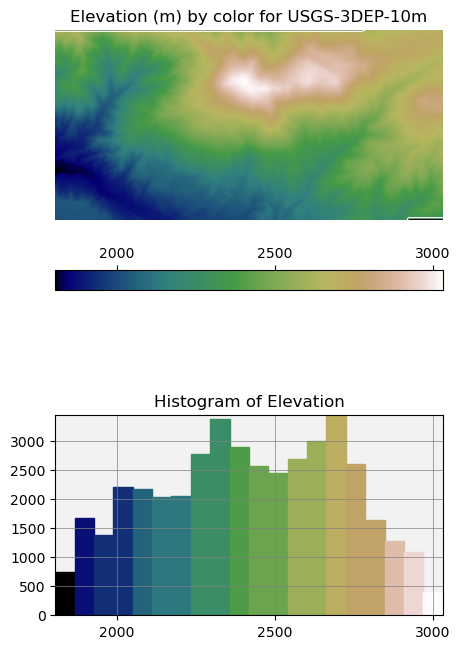

In [9]:

totalsize, full_zip_file_name = TouchTerrain.get_zipped_tiles(**args) # args are in a dict
print("\nDONE!\n\nCreated zip file", full_zip_file_name,  "%.2f" % totalsize, "Mb")


In [10]:
# If you want to unzip the zip file, run this cell
# (You will need to do this before using k3d for visualization)

import os.path
from glob import glob
folder, file = os.path.splitext(full_zip_file_name) # get folder of zip file

# unzip the zipfile into the folder it's already in
import zipfile
zip_ref = zipfile.ZipFile(full_zip_file_name, 'r')
zip_ref.extractall(folder)
zip_ref.close()
print ("unzipped files from", full_zip_file_name, "into the folder", folder)
print (folder, "contains these files:")
for f in glob(folder + os.sep + "*.*"): print(" ", f)

unzipped files from tmp/myterrain.zip into the folder tmp/myterrain
tmp/myterrain contains these files:
  tmp/myterrain/10m_-116.81_34.19_DEMandHistogram.png
  tmp/myterrain/10m_-116.81_34.19.tif
  tmp/myterrain/10m_-116.81_34.19_tile_1_1.STL
  tmp/myterrain/logfile.txt


## Visualize the STL file(s)

- If you want to visualize your model(s), install k3d (`pip install k3d`) and run the cell below
- this won't work with OBJ files, as k3d can't read them in.
- binary STL should work, but ascii may not.


In [11]:
import k3d
from glob import glob

# get all stl files (tiles) in that folder
mesh_files = glob(folder + os.sep + "*.STL")

plot = k3d.plot()

# Add all tiles with a random color
from random import randint
for m in mesh_files:
    col = (randint(0,255) << 16) + (randint(0,255) << 8) + randint(0,255) # random rgb color as hex
    print("adding to viewer:", m, hex(col))
    buf = open(m, 'rb').read()
    plot += k3d.stl(buf, color=col)
plot.display()

adding to viewer: tmp/myterrain/10m_-116.81_34.19_tile_1_1.STL 0x90848c


Output()

In [12]:
# If you plan to refine your parameters and create different models, you should run this cell to remove 
# the preview folder first, otherwise the preview could show you old models.

from shutil import rmtree
rmtree(folder)